In [ ]:
!pip install trimesh pyrender tqdm numpy

In [1]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import trimesh
import pyrender
import tqdm
from time import process_time 
import torch
import time
from plot_image_grid import image_grid
from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     Viewer, OffscreenRenderer
import logging

In [29]:
DATA_DIR = "../docs/tutorials/data"
shapenet_folder = os.path.join(DATA_DIR, "shapenet_sample")
obj_list = []

with open(os.path.join(shapenet_folder, 'pathlist.txt')) as filehandle:
    for line in tqdm.tqdm(filehandle, desc = 'Loading Meshes'):
        obj_folder = line.strip()
        obj_name = os.path.join(shapenet_folder, obj_folder, 'models/model_normalized.obj')
        obj_list.append(obj_name)

obj_list = obj_list[0:129]

Loading Meshes: 128it [00:00, 72717.18it/s]


In [30]:
def trimesh_to_pyrender(scene, ambient_light=None):
    """                                                                                              
    Convert a trimesh scene to a pyrender scene.                                                     
                                                                                                     
    Parameters                                                                                       
    --------------                                                                                   
    scene : trimesh.Scene                                                                            
      Scene with trimesh.Trimesh, trimesh.PointCloud object                                          
    ambient_light : (3,) float or None                                                               
      Ambient light in the scene                                                                     
                                                                                                     
    Returns                                                                                          
    -----------                                                                                      
    scene_pr : pyrender.scene.Scene                                                                  
      Contains same geometry as trimesh version                                                      
    """
    # convert trimesh geometries to pyrender geometries                                              
    geometries = {name: pyrender.Mesh.from_trimesh(geom)
                  for name, geom in scene.geometry.items()}

    # wrap passed ambient light                                                                      
    if ambient_light is	not None:
        ambient_light =	np.array(ambient_light, dtype=np.float64)

    # create the pyrender scene object                                                               
    scene_pr = pyrender.Scene(ambient_light=ambient_light)

    # add every node with geometry to the pyrender scene                                             
    for node in scene.graph.nodes_geometry:
        pose, geom_name = scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)

    return scene_pr

In [31]:
def rendering(scene):
    
    view = (30, 45)  # ele  azim
    camera, light, camera_position = get_camera_position(scene, vfov = 45, 
                                    elev = view[0], azim = view[1], 
                                    aspect_ratio = 1.0, dis_buffer = 1.0)
    
    object_centroid = scene.centroid
    camera_pose = get_camera_pose(camera_position, object_centroid)
    scene.add(camera, pose=camera_pose) #
    # Set up the light -- a single spot light in the same spot as the camera
    scene.add(light, pose=camera_pose)
    
    # Render the scene
    r = pyrender.OffscreenRenderer(224, 224)
    
    color, depth = r.render(scene)
    return color

In [32]:
def get_camera_pose(camera_position, target_position):
    #print('Enter get_camera_pose')
    camera_pose = np.zeros((4,4))
    forward =  camera_position - target_position  
    forward = forward/np.linalg.norm(forward)
    left = np.cross(np.array([0, 1, 0]),forward)
    up = np.cross(forward, left)
    camera_pose[:3,0] = left
    camera_pose[:3,1] = up
    camera_pose[:3,2] = forward
    camera_pose[:3,3] = camera_position
    camera_pose[-1,-1] = 1
    
    return camera_pose
    

In [50]:
def get_camera_position(scene, vfov = 45, elev = 30, azim = 30, aspect_ratio = 1.0, dis_buffer= 1.0):
    
    hfov = 2 * np.arctan(np.tan(np.pi * (vfov/2) /180) * aspect_ratio)
    hfov = hfov * 180 /np.pi
    
    bbox = scene.bounds
    bbox_med = ((bbox[0][0] + bbox[1][0])/2, (bbox[0][1] + bbox[1][1])/2,
             (bbox[0][2] + bbox[1][2])/2 )
    bbox_size = ((bbox[1][0] - bbox[0][0]), (bbox[1][1] - bbox[0][1]),
                    (bbox[1][2] - bbox[0][2]) )    # bbox x → object width  bbox y → object height bbox z → object front back 
#    print(bbox_size)
    width = np.abs(bbox_size[0] * np.cos(np.pi * azim / 180)) + np.abs(bbox_size[2] * np.sin(np.pi * azim / 180))
    height = np.abs(bbox_size[1] * np.cos(np.pi * elev / 180)) + np.abs(bbox_size[2] * np.sin(np.pi * elev / 180))
    
#    print(width)
#    print(height)
    
    camera_dist_v = (height/2) * (np.tan(np.pi * (vfov / 2)/180) ** -1)
    camera_dist_h = (width/2) * (np.tan(np.pi * (hfov / 2)/180) ** -1)
    camera_dist = max(camera_dist_h, camera_dist_v)
    
    angle = np.arctan(bbox_size[0]/bbox_size[2]) * 180/np.pi
    diagonal_dist = np.sqrt((bbox_size[0]/2)**2 + (bbox_size[2]/2)**2 + (bbox_size[1]/2)**2 )
#    diagonal_dist = diagonal_dist/np.cos(np.pi * azim / 180)
    
    camera_dist = camera_dist + diagonal_dist
    camera_dist = camera_dist * dis_buffer
    
    x_offset = camera_dist * np.cos(np.pi * elev / 180) * np.sin(np.pi * azim / 180)
    y_offset = camera_dist * np.sin(np.pi * elev / 180)
    z_offset = camera_dist * np.cos(np.pi * elev / 180) * np.cos(np.pi * azim / 180)
    
    
    camera_position = np.array([bbox_med[0] + x_offset, 
                            bbox_med[1] + y_offset, 
                              bbox_med[2] - z_offset])
    
    camera = pyrender.PerspectiveCamera(
        yfov=np.pi / 180 * vfov,
        znear= camera_dist - 0.5, zfar= camera_dist + 0.5
    )
    
    light = pyrender.SpotLight(color=np.ones(3), intensity=7.0,
                               innerConeAngle=np.pi/16.0)
    #print('Output get_camera_position')
    return camera, light, camera_position

   

In [34]:
class DisableLogger():
    def __enter__(self):
       logging.disable(logging.CRITICAL)
    def __exit__(self, a, b, c):
       logging.disable(logging.NOTSET)

In [35]:
def loading_one(mesh_path):
    with DisableLogger():
        mesh_or_scene =  trimesh.load(mesh_path)
        if isinstance(mesh_or_scene, trimesh.Trimesh):
            mesh = pyrender.Mesh.from_trimesh(mesh_or_scene) 
            scene = pyrender.Scene()
            scene.add(mesh)
            return scene
        else:
            scene = pyrender.Scene.from_trimesh_scene(mesh_or_scene)
            return scene
    

In [36]:
from multiprocessing import Pool
num_processors = 15
start_time = time.time()

##################################################################################
pool = Pool(processes = num_processors)
print("Request Pool: --- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
scene_list = pool.map(loading_one, obj_list)
print("Loading Mesh: --- %s seconds ---" % (time.time() - start_time))

#pool.close()
#pool.join()


Request Pool: --- 0.3889122009277344 seconds ---
Loading Mesh: --- 4.523285388946533 seconds ---


In [37]:
import multiprocessing
from multiprocessing import Pool

num_processors = 15
start_time = time.time()

##################################################################################
pool = Pool(processes = num_processors)
print("Request Pool: --- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
images = pool.map(rendering, scene_list)
print("Rendering Mesh: --- %s seconds ---" % (time.time() - start_time))

print(len(images))
#pool.close()
#pool.join()

Request Pool: --- 0.16253662109375 seconds ---
Rendering Mesh: --- 4.417767286300659 seconds ---
128


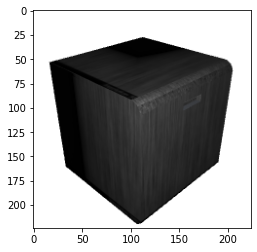

In [49]:
import matplotlib.pyplot as plt
color = images[60]
plt.imshow(color)


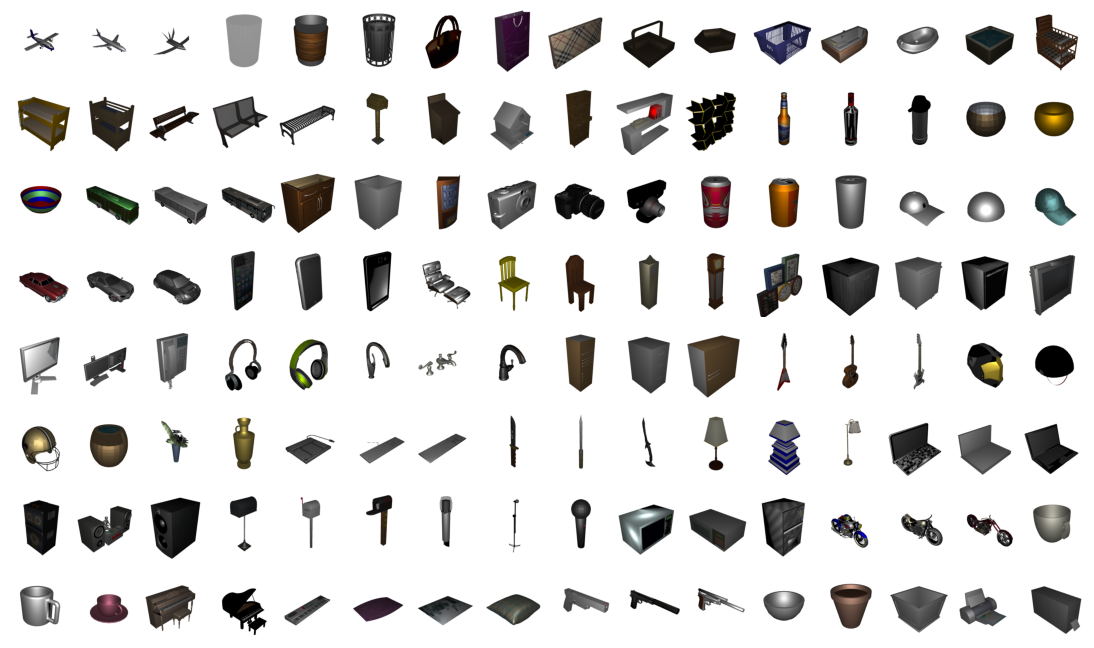

In [39]:
image_grid(images, rows=8, cols=16, rgb=True)

In [40]:
images = np.zeros((128,224,224,3),dtype=np.int)
start_time = time.time()
##################################################################################
for idx, scene in tqdm.tqdm(enumerate(scene_list), desc = 'Rendering Mesh'):
    color = rendering(scene)
    images[idx] = color
##################################################################################
print("Rendering Mesh: --- %s seconds ---" % (time.time() - start_time))


Rendering Mesh: 128it [00:16,  7.56it/s]

Rendering Mesh: --- 16.94200849533081 seconds ---


#### 

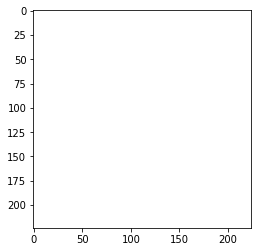

In [12]:
with DisableLogger():
    scene_list = []
    start_time = time.time()
    for obj_name in tqdm.tqdm(obj_list, desc = 'Loading Mesh'):
        # Load the FUZE bottle trimesh and put it in a scene
        mesh_or_scene =  trimesh.load(obj_name)
        if isinstance(mesh_or_scene, trimesh.Trimesh):
            mesh = pyrender.Mesh.from_trimesh(mesh_or_scene) 
            scene = pyrender.Scene()
            scene.add(mesh)
        else:
            scene = pyrender.Scene.from_trimesh_scene(mesh_or_scene)
        scene_list.append(scene)
    print("Loading Mesh: --- %s seconds ---" % (time.time() - start_time))

Loading Mesh: 100%|██████████| 128/128 [00:14<00:00,  8.54it/s]

Loading Mesh: --- 14.986754894256592 seconds ---
